**1️⃣ Import libraries**

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    accuracy_score
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


In [14]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import pandas as pd

file_path = "/content/drive/MyDrive/loan_approval_dataset.xlsx"
df = pd.read_excel(file_path)
df.head()


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


**2️⃣ Load dataset**

In [16]:
df = pd.read_excel("/content/drive/MyDrive/loan_approval_dataset.xlsx")

df.columns = df.columns.str.strip()

# detect target column
target_col = [c for c in df.columns if "loan" in c.lower() and "status" in c.lower()][0]

# map Approved/Rejected
df[target_col] = df[target_col].astype(str).str.strip().map({"Approved": 1, "Rejected": 0})
df = df.dropna(subset=[target_col])

# drop ID column if exists
if "loan_id" in df.columns:
    df = df.drop(columns=["loan_id"])

# ============================================
# 3️⃣ Split features and target
# ============================================

X = df.drop(columns=[target_col])
y = df[target_col]

# Identify column types
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = X.select_dtypes(include=["object"]).columns


**3️⃣ Split features and target**

In [17]:
X = df.drop(columns=[target_col])
y = df[target_col]

# Identify column types
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = X.select_dtypes(include=["object"]).columns

**4️⃣ Preprocessing**

In [18]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

**5️⃣ Train-Test Split**

In [19]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


**6️⃣ Define SMOTE + Models**

In [20]:
smote = SMOTE(random_state=42)

log_reg_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('classifier', LogisticRegression(solver='liblinear', max_iter=500))
])

tree_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('classifier', DecisionTreeClassifier(max_depth=5, random_state=42))
])


**7️⃣ Train models**

In [21]:
log_reg_pipeline.fit(X_train, y_train)
tree_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['no_of_dependents', 'income_annum', 'loan_amount', 'loan_term',
       'cibil_score', 'residential_assets_value', 'commercial_assets_value',
       'luxury_assets_value', 'bank_asset_value'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['education', 'self_employed'], dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 DecisionTreeClassifier(max_depth=5, random_state=42))])

**8️⃣ Evaluation Function**

In [22]:
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    report = classification_report(y_test, y_pred, output_dict=True)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    return {
        "Model": name,
        "Precision": report['1']['precision'],
        "Recall": report['1']['recall'],
        "F1-Score": report['1']['f1-score'],
        "Accuracy": acc,
        "ROC AUC": auc,
        "y_pred": y_pred,
        "y_proba": y_proba
    }

# Evaluate both models
results_log = evaluate_model(log_reg_pipeline, X_test, y_test, "Logistic Regression")
results_tree = evaluate_model(tree_pipeline, X_test, y_test, "Decision Tree")

**9️⃣ Comparison Table**

In [23]:

comparison_df = pd.DataFrame([
    {k: v for k, v in results_log.items() if k not in ['y_pred','y_proba']},
    {k: v for k, v in results_tree.items() if k not in ['y_pred','y_proba']}
])

print("\n=== Model Performance Comparison ===")
display(comparison_df.style.background_gradient(cmap="Blues").format(precision=4))


=== Model Performance Comparison ===


,Model,Precision,Recall,F1-Score,Accuracy,ROC AUC
0,Logistic Regression,0.9515,0.9228,0.9369,0.9227,0.9732
1,Decision Tree,0.9865,0.9661,0.9762,0.9707,0.9916


**🔟 Plot ROC Curves**

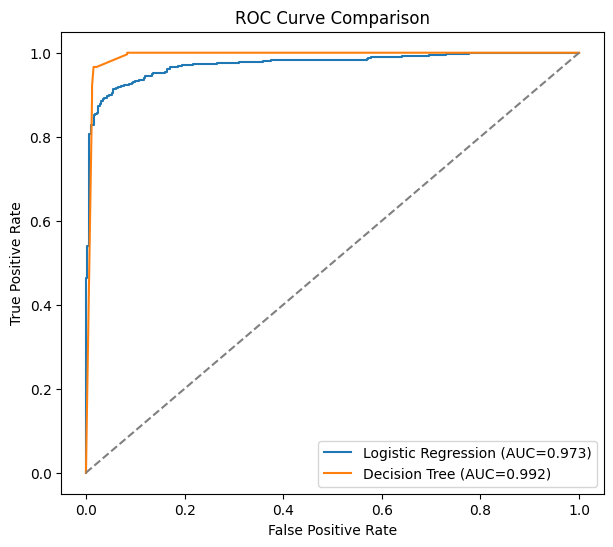

In [24]:

fpr_log, tpr_log, _ = roc_curve(y_test, results_log["y_proba"])
fpr_tree, tpr_tree, _ = roc_curve(y_test, results_tree["y_proba"])

plt.figure(figsize=(7,6))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC={results_log['ROC AUC']:.3f})")
plt.plot(fpr_tree, tpr_tree, label=f"Decision Tree (AUC={results_tree['ROC AUC']:.3f})")
plt.plot([0,1],[0,1],'--',color='gray')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


**11️⃣ Plot Precision-Recall Curves**

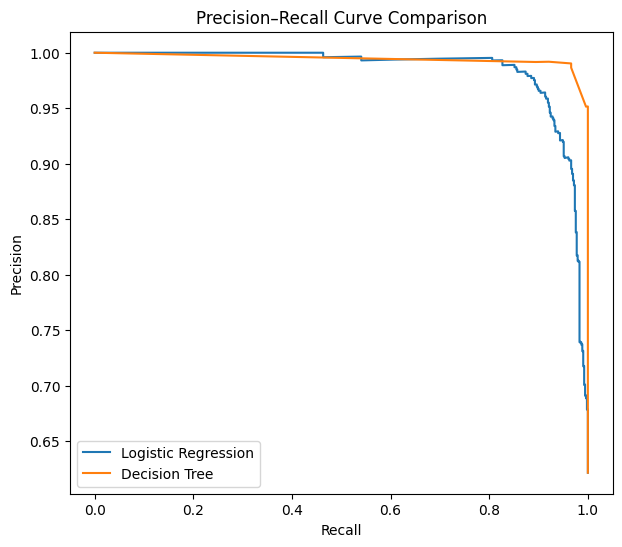

In [25]:
prec_log, rec_log, _ = precision_recall_curve(y_test, results_log["y_proba"])
prec_tree, rec_tree, _ = precision_recall_curve(y_test, results_tree["y_proba"])

plt.figure(figsize=(7,6))
plt.plot(rec_log, prec_log, label="Logistic Regression")
plt.plot(rec_tree, prec_tree, label="Decision Tree")
plt.title("Precision–Recall Curve Comparison")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()